In [3]:
import os 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
from load_data import *
from itertools import chain
from collections import Counter
import re
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# 1. Extract labeled data

In [12]:
device_path = "/Volumes/TOSHIBA EXT/images"
images_path = os.listdir("/Volumes/TOSHIBA EXT/images")
images_path.sort()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/TOSHIBA EXT/images'

In [13]:
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
prefix = "https://airbnb.de"
suffix = "/photos"
urls = listings["listing_url"]
ids = listings["id"]

In [4]:
images_path = pd.Series(images_path)
listing_ids = images_path.str.extract("(^\d*)").values

In [80]:
data = open("labels_raw.json")
labels_raw = json.load(data)

## Get an overview over the most common words

In [81]:
ids = list(labels_raw.keys())
all_labels_raw = []
for i in ids:
    all_labels_raw += labels_raw[i]
words_raw = pd.Series(all_labels_raw).str.lower().str.split()
all_words_raw = list(chain.from_iterable(list(words_raw.values)))
c = Counter(all_words_raw)
c.most_common(50)


[('image', 55910),
 ('listing', 53514),
 ('the', 5824),
 ('2', 5523),
 ('1', 5515),
 ('bedroom', 5203),
 ('room', 4962),
 ('3', 4830),
 ('4', 4273),
 ('5', 4050),
 ('and', 3992),
 ('6', 3613),
 ('with', 3573),
 ('kitchen', 3246),
 ('7', 3225),
 ('living', 3117),
 ('8', 2918),
 ('bathroom', 2865),
 ('9', 2626),
 ('10', 2510),
 ('of', 2351),
 ('to', 2222),
 ('a', 2126),
 ('11', 2122),
 ('12', 1888),
 ('in', 1792),
 ('13', 1674),
 ('area', 1658),
 ('from', 1649),
 ('14', 1500),
 ('15', 1420),
 ('double', 1366),
 ('view', 1365),
 ('bed', 1349),
 ('is', 1289),
 ('16', 1199),
 ('dining', 1199),
 ('for', 1163),
 ('-', 1120),
 ('garden', 1110),
 ('17', 1101),
 ('18', 1033),
 ('19', 957),
 ('20', 922),
 ('shower', 858),
 ('full', 809),
 ('21', 777),
 ('on', 777),
 ('front', 749),
 ('main', 728)]

We can use the keywords bedroom, bed, living, bathroom, kitchen, garden and dining to extract pictures containing these types of rooms. 
Therefore we construct a loop over all listings which searches for one of the words in the raw labels and loads the corresponding image, saving it with the listing id and its category.

In [175]:
images = []
labels = []
listing_ids = []
device_path = "data/images_resized/"

for id in tqdm(ids):
    sample = labels_raw[id]

    bedrooms_tmp = []
    bathrooms_tmp = []
    living_rooms_tmp = []
    kitchen_tmp = []
    dining_tmp = []
    garden_tmp = []
    front_tmp= []

    for i in sample:
        pattern = r"view"
        i = re.sub(pattern, "", i)

        regex = re.compile("(^bed| bed |bed$|bedroom)")
        bedrooms_tmp.append(bool(re.search(regex, i)))

        regex = re.compile("(^bath| bath|shower)")
        bathrooms_tmp.append(bool(re.search(regex, i)))

        regex = re.compile("(living room|livingroom)")
        living_rooms_tmp.append(bool(re.search(regex, i)))

        regex = re.compile("kitchen")
        kitchen_tmp.append(bool(re.search(regex, i)))

        regex = re.compile("(dining room|diningroom|dining area|dining hall)")
        garden_tmp.append(bool(re.search(regex, i)))

        regex = re.compile("(^garden |^park )")
        garden_tmp.append(bool(re.search(regex, i)))

        regex = re.compile("(house.*front)")
        front_tmp.append(bool(re.search(regex, i)))

    bedrooms_tmp = np.where(np.array(bedrooms_tmp))[0]
    bathrooms_tmp = np.where(np.array(bathrooms_tmp))[0]
    living_rooms_tmp = np.where(np.array(living_rooms_tmp))[0]
    kitchen_tmp = np.where(np.array(kitchen_tmp))[0]
    garden_tmp = np.where(np.array(garden_tmp))[0]
    garden_tmp = np.where(np.array(garden_tmp))[0]
    front_tmp = np.where(np.array(front_tmp))[0]

    for i in bedrooms_tmp:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("bedroom")
        listing_ids.append(id+"_"+str(i))

    for i in bathrooms_tmp:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("bathrooms")
        listing_ids.append(id+"_"+str(i))

    for i in living_rooms_tmp:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("living_rooms")
        listing_ids.append(id+"_"+str(i))

    for i in kitchen_tmp:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("kitchen")
        listing_ids.append(id+"_"+str(i))

    for i in dining_tmp:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("dining")
        listing_ids.append(id+"_"+str(i))

    for i in garden_tmp:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("garden")
        listing_ids.append(id+"_"+str(i))

    for i in front_tmp:
        path = device_path + "/" + id+"_"+str(i)+".png"
        img = cv2.imread(path)
        images.append(img)
        labels.append("front")
        listing_ids.append(id+"_"+str(i))

100%|██████████| 6976/6976 [00:18<00:00, 383.49it/s] 


In [176]:
listing_ids

['44077_2',
 '44077_34',
 '44077_35',
 '44077_0',
 '85148_5',
 '85148_6',
 '85148_9',
 '85148_11',
 '85148_7',
 '85156_2',
 '85156_5',
 '162809_0',
 '162809_2',
 '162809_3',
 '162809_22',
 '162809_4',
 '165828_1',
 '165828_1',
 '237465_2',
 '237465_4',
 '237465_2',
 '245893_0',
 '245893_4',
 '245903_0',
 '245903_4',
 '245903_5',
 '245903_2',
 '292757_7',
 '292757_10',
 '292757_11',
 '292757_12',
 '292757_13',
 '292757_14',
 '292757_16',
 '292757_19',
 '292757_20',
 '292757_17',
 '302554_0',
 '302554_1',
 '302554_2',
 '302554_3',
 '302554_10',
 '302554_5',
 '302634_0',
 '302634_1',
 '302634_11',
 '302634_1',
 '302634_12',
 '302634_0',
 '315698_1',
 '315698_0',
 '315698_6',
 '315698_3',
 '386860_15',
 '386860_16',
 '386860_21',
 '386860_16',
 '386860_17',
 '393631_5',
 '393631_9',
 '393631_10',
 '393631_14',
 '393631_15',
 '393631_16',
 '393631_35',
 '393631_2',
 '393631_25',
 '393631_1',
 '393631_17',
 '419987_7',
 '419987_0',
 '424596_21',
 '424596_12',
 '424596_23',
 '424596_12',
 '42

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_40963/762385813.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for j, i in zip(np.array(images)[filter][:15], np.array(listing_ids)[filter][:15]):


44077_2


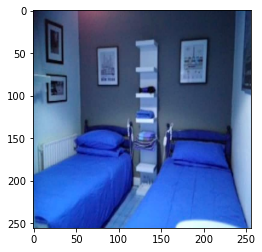

44077_34


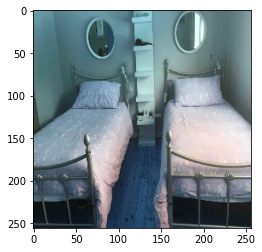

44077_35


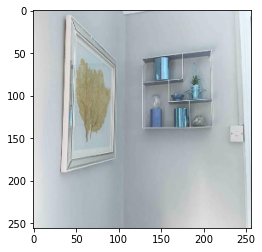

85148_5


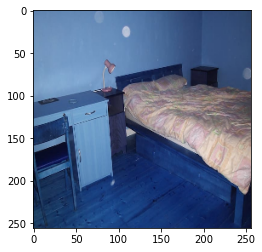

85148_6


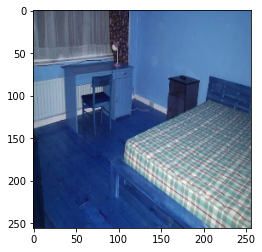

85156_2


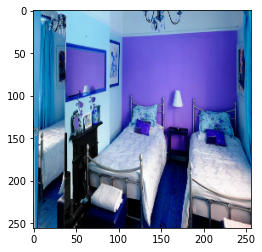

85156_5


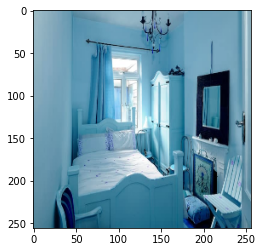

162809_0


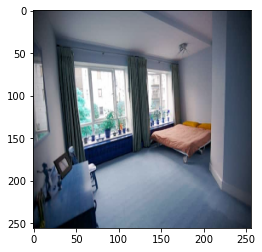

162809_2


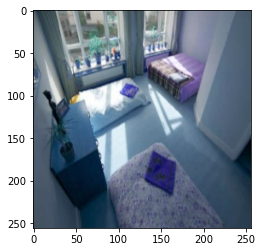

162809_3


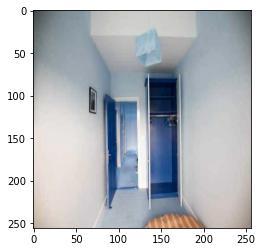

162809_22


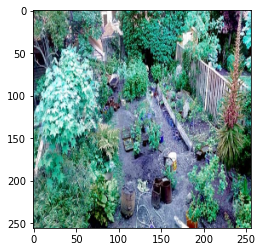

237465_2


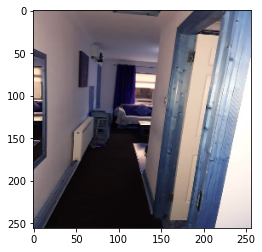

237465_4


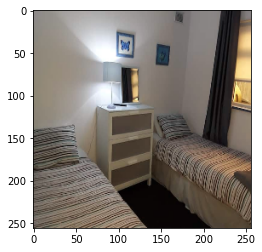

245893_0


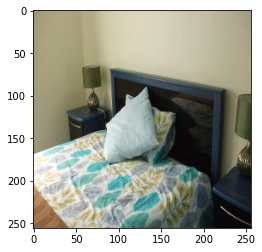

245903_0


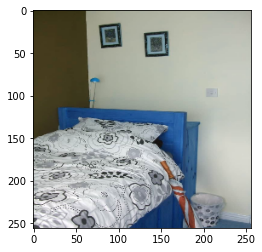

In [179]:
filter = [np.array(labels) == "bedroom"]
for j, i in zip(np.array(images)[filter][:15], np.array(listing_ids)[filter][:15]):
    print(i)
    plt.imshow(j)
    plt.show()


In [193]:
labels_raw["162809"][22]

"May 2020 Hugelkultur bed like a Celtic burial mound. Bees love the tall, flowering echium. Out of view are bug 'airbnb' hotels. Insects love it too; not untill they get gobbled up by the visiting birds - goldfinches, dunnoks, wrens + robins. "

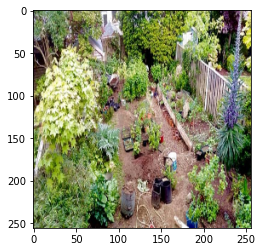

In [9]:
img = plt.imread("data/images_resized/162809_22.png")
plt.imshow(img)

## Instead of labels extract only embeddings from pretrained net first

In [8]:
from pathlib import Path
import pandas as pd
from image_helpers import *
from sklearn.cluster import MiniBatchKMeans, OPTICS
import cv2 
import matplotlib.pyplot as plt


In [2]:
# Let's define some paths where to save images, tfrecords and embeddings
path_images = "data/images_resized"
path_tfrecords = "data/tfrecords"
path_embeddings = "data/embeddings"

In [ ]:
write_tfrecord(image_folder=path_images,output_folder=path_tfrecords,num_shards=500)

In [ ]:
run_inference(tfrecords_folder=path_tfrecords,output_folder=path_embeddings,batch_size=10)

In [ ]:
emb_files = os.listdir("data/embeddings")
emb_files = [path_embeddings + "/" + f for f in emb_files]

data = [pd.read_parquet(f, engine='fastparquet') for f in emb_files] 
merged_data = pd.concat(data, ignore_index = True)
merged_data = merged_data.set_index("image_name", drop = True)
merged_data.index = [i.decode("UTF-8") for i in merged_data.index]
emb_df = pd.DataFrame(merged_data["embedding"].to_list(), index = merged_data.index)
emb_df["ids"] = emb_df.index


In [232]:
emb_df.to_csv("data/embeddings/embeddings.csv")

In [ ]:
emb_df = pd.read_csv("data/embeddings/embeddings.csv")

In [221]:
X = emb_df.drop("ids", axis = 1).values
X = (X-X.mean(axis=0))/X.std(axis=0)

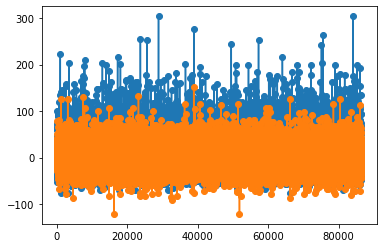

In [224]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

plt.plot(X_pca, marker = "o")

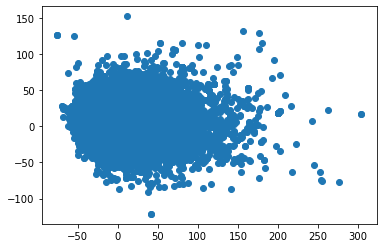

In [228]:
plt.scatter(X_pca[:,0], X_pca[:,1])

In [76]:
kmeans = MiniBatchKMeans(n_clusters=100, random_state=0, batch_size=10000, max_iter=1000).fit(X)
clusters = kmeans.predict(X)

In [229]:
clusters = OPTICS(min_samples = 20, metric = "l2").fit_predict(X)

KeyboardInterrupt: 

In [67]:
np.unique(clusters)

array([0])

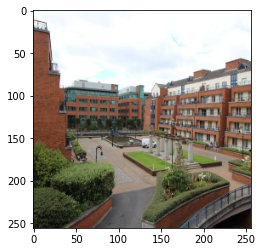

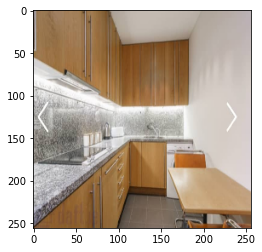

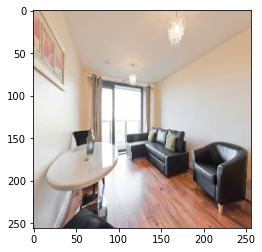

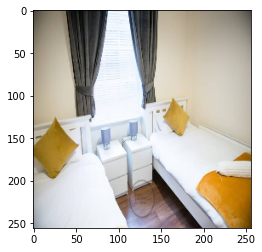

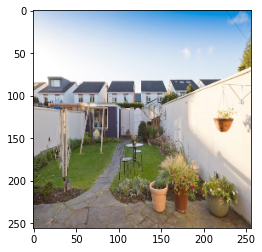

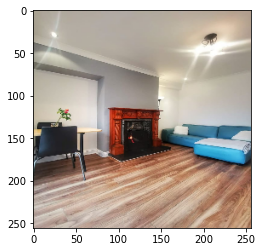

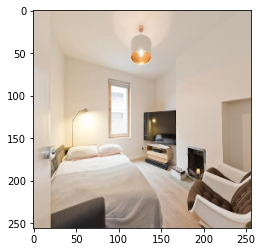

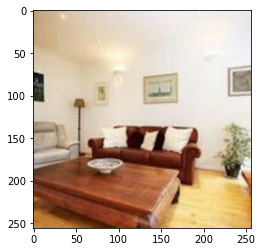

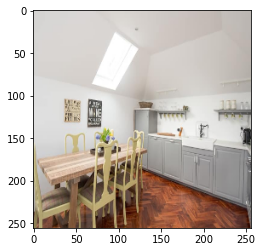

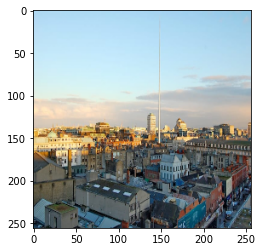

In [77]:
filter = clusters == 2
images_names = emb_df.index[filter]
images_paths = [path_images + "/" + i +".png" for i in images_names]

for img in images_paths[:10]:
    img_tmp = plt.imread(img)
    plt.imshow(img_tmp)
    plt.show()

Create new variables number of images and brightness

In [75]:
img_dir = os.listdir("data/images")

In [76]:
img_ids = pd.Series(img_dir).str.split("_", expand = True)[0]
img_ids = img_ids[~(img_ids == ".DS")]

In [84]:
from collections import Counter
df_img = pd.DataFrame({"count": Counter(img_ids)})

In [63]:
from PIL import ImageStat, Image

In [78]:
def brightness(id, folder = "data/images/"):
   filter = pd.Series(img_dir).str.contains(id+"_").values
   id_dir = np.array(img_dir)[filter]
   bright = 0
   for id_img in id_dir:
      im = Image.open(folder+id_img).convert('L')
      bright += ImageStat.Stat(im).mean[0]
   return bright/len(id_dir)

In [79]:
brightness_list = []
for i in df_img.index.values:
    brightness_list.append(brightness(i))
    

In [85]:
df_img["brightness"] = brightness_list

In [86]:
df_img.reset_index()

,index,count,brightness
0,10006474,6,153.609250
1,10007446,6,111.985657
2,10027351,8,130.525506
3,10048879,5,112.762477
4,10069364,9,124.934444
...,...,...,...
6310,9972553,6,112.549755
6311,998407,18,127.578918
6312,9995720,5,99.862110
6313,9998986,16,138.007688
